In [1]:
from __future__ import print_function, division
import cv2 as cv2
import os
import torch
import torchvision
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from typing import Tuple, List, Type, Dict, Any
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
import torchvision.models as models
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import time
from tqdm import tqdm
import os.path
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import os
from threading import Thread
from queue import Empty, Queue
import threading
from sklearn.utils import shuffle
import random
from typing import Tuple, List, Type, Dict, Any
import accimage
from libs import *
from libs.plot_examples import plot_examples, plot_examples_segmentation
from torch.utils.tensorboard import SummaryWriter
from os.path import join, isfile, isdir
from seg_losses import *

In [2]:
device1 = torch . device ( "cuda:0" if torch . cuda . is_available () else "cpu" )
device2 = torch.device('cpu')

In [3]:
img = cv2.imread('images/img-2014-09-22T15-01-17devID2.jpg')
img = cv2.resize(img, (512,512))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#plt.imshow(img)

In [4]:
model = UnetCoordConv(activation = Mish)
state_dict = torch.load('./MK_checkpoints/model_ep0028.pt')
model.load_state_dict(state_dict)
model = model.to(device1)  # отправили на видеокарту
model = model.eval()

In [5]:
def test_unet(image):
    image = np.transpose(img,(2, 0, 1)) # меняем каналы для тензора
    image = image[np.newaxis, ...] # новая ось, потому что модели нужен 4д кун
    image = torch.from_numpy(image) # в тензор
    image = image.float() # ебля с типами данных
    image = image.to(device1)  # отправили на видеокарту
    out = model(image)
    out_np = out.detach().cpu().numpy()
    out_np = np.squeeze(out_np) # удалили ось
    return out_np

plt.imshow(test_unet(img), origin='lower', cmap='gray')

In [6]:
out_img = test_unet(img)

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [7]:
def resize (image):
    out_img = cv2.resize(image, (1920, 1920)) # обратный ресайз
    out_img = (out_img>0.5).astype(np.uint8) # убрали проблемы интерполяции
    return out_img

In [8]:
def findXYR(image):
    x_matrix = np.arange(0, 1920, 1)[np.newaxis,:] # далее находим центр масс и радиус
    x_matrix = np.tile(x_matrix, (1920, 1))

    y_matrix = np.arange(0, 1920, 1)[:, np.newaxis]
    y_matrix = np.tile(y_matrix, (1, 1920))

    x_center = np.sum(image*x_matrix)/np.sum(out_img)
    y_center = np.sum(image*y_matrix)/np.sum(out_img)
    radius = np.sqrt(np.sum(image)/np.pi)

    out_img_rgb = cv2.cvtColor(image*255, cv2.COLOR_GRAY2RGB)
    return x_center,y_center,radius

In [9]:
def classic_algorithm(image):
    img_classic = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_classic = cv2.resize(img_classic, (1920, 1920))
    img_classic_th = (img_classic>=250).astype(np.uint8)
    return img_classic_th

In [10]:
#plt.imshow(out_img_rgb, origin='lower')

In [11]:
class SunLandmarksDatasetClassic(Dataset):
    """Sun Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file,delimiter=',') # чертов разделитель 
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #landmarks_frame.iloc[n, 0]
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0]) #self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        image = image 
        #image = cv2.resize(image, (512,512))# тут применяю аугментацию
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(1, 3)
        landmarks = landmarks # тут применяю аугментацию к переменной
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [12]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [13]:
sun_dataset_test = SunLandmarksDatasetClassic(csv_file='sun_disk_pos_database01test.csv',
                                           root_dir='/app/images',
                                           transform=transforms.Compose([
                                               ToTensor()
                                           ]))
val_loader = torch.utils.data.DataLoader(sun_dataset_test, batch_size=1,drop_last=False)

In [14]:
class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            CoordConv(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            CoordConv(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(num_features=192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            CoordConv(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=384),
            nn.ReLU(inplace=True),
            CoordConv(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            CoordConv(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(num_features=4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(num_features=4096),
            nn.ReLU(inplace=True),
#             nn.Linear(4096,num_classes),
            nn.Linear(in_features=4096, out_features=256, bias=True),
            nn.BatchNorm1d(num_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128, bias=True),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(), # SeLU или GeLU возможно подойдут лучше, надо поиграться
#             nn.Linear(in_features=128, out_features=3, bias=True)
            
            ###### Coords only - without radius ######
            nn.Linear(in_features=128, out_features=2, bias=True)
            ###### Coords only - without radius ######
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
class AddCoords(nn.Module):

    def __init__(self, with_r=False):
        super().__init__()
        self.with_r = with_r

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        xx_channel = xx_channel.float() / (x_dim - 1)
        yy_channel = yy_channel.float() / (y_dim - 1)

        xx_channel = xx_channel * 2 - 1
        yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        if self.with_r:
            rr = torch.sqrt(torch.pow(xx_channel.type_as(input_tensor) - 0.5, 2) + torch.pow(yy_channel.type_as(input_tensor) - 0.5, 2))
            ret = torch.cat([ret, rr], dim=1)

        return ret


class CoordConv(nn.Module):

    def __init__(self, in_channels, out_channels, with_r=False, **kwargs):
        super().__init__()
        self.addcoords = AddCoords(with_r=with_r)
        in_size = in_channels+2
        if with_r:
            in_size += 1
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [17]:
alexnet = torch.load('./saved_models/best_model_alexnet3.pth')
#|state_dict = torch.load('./MK_checkpoints/model_ep0028.pt')

946 955 127


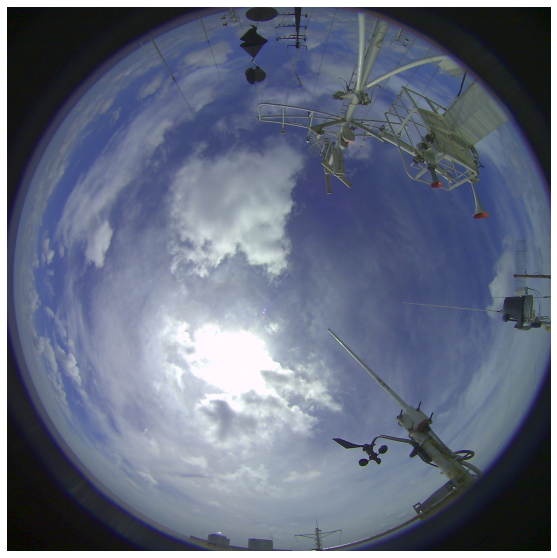

In [74]:
for batch_idx , data in enumerate(val_loader):
    data_image = data['image'].float()
    data_image = data_image.to(device1) # отправили на GPU
    target = torch.squeeze(data['landmarks'])
    data_out = alexnet(data_image) # получили сегментированную фотку
    #print(data_out[0,0].to('cpu'))
    image = np.squeeze(data_image.detach().cpu().numpy())
    image = image.transpose((1, 2, 0)).astype('int')
    f = plt.figure(figsize=(10,10),frameon = False)
    plt.imshow(image)
    plt.axis('off')
    out_np = np.squeeze(data_out.detach().cpu().numpy()) 
    #out_img_rgb2 = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    print(int(out_np[0]*1920),int(out_np[1]*1920),int(out_np[2]*1920))
    x_center = int(out_np[0]*1920)
    y_center = int(out_np[1]*1920)
    r =        int(out_np[2]*1920)
   # cv2.circle(out_img_rgb2, (int(x_center), int(y_center)), int(r), [255,0,255], 4)
    #image = image.copy()
    image = np.ascontiguousarray(image, dtype=np.uint8)
    out_img_wcircle2  = cv2.circle(image, (x_center, y_center), r, [255,0,255], 4)
    #plt.imshow(out_img_wcircle2)
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     fig.suptitle('Horizontally stacked subplots')
#     ax1.imshow(image)
#     ax2.imshow(out_img_wcircle2)
#     f = plt.figure(figsize=(10,10),frameon = False)
#     plt.imshow(image)
#     plt.axis('off')
    #plt.imshow(out_img_wcircle2)
    break

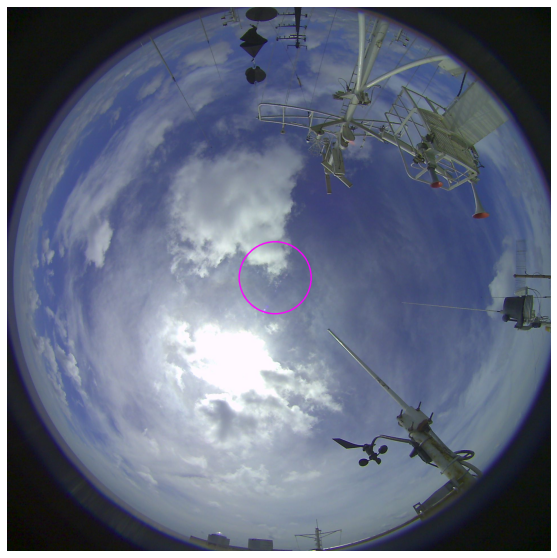

In [70]:
g = plt.figure(figsize=(10,10),frameon = False)
plt.axis('off')
plt.imshow(image)

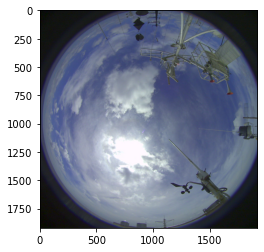

In [34]:
loss_valueXY = []
loss_valueR = []
loss_valueR2 = []
for batch_idx , data in enumerate(val_loader):
    data_image = data['image'].float()
    data_image = data_image.to(device1) # отправили на GPU
    target = torch.squeeze(data['landmarks'])
    data_out = alexnet(data_image) # получили сегментированную фотку
    #print(data_out[0,0].to('cpu'))
    image = np.squeeze(data_image.detach().cpu().numpy())
    image = image.transpose((1, 2, 0)).astype('int')
    out_np = np.squeeze(data_out.detach().cpu().numpy())
    target_np = np.squeeze(target.detach().cpu().numpy())
    
    plt.imshow(image)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Horizontally stacked subplots')
    ax1.plot(image)
    ax2.plot(image)
    #print(data['image'].float().detach().cpu().numpy().shape)
    break
   # print(out_np, type(out_np))
#     out_np = np.squeeze(data_out.detach().cpu().numpy())
    #target_np = np.squeeze(target.detach().cpu().numpy())
    
    
#     out_img = cv2.resize(out_np, (1920, 1920)) # обратный ресайз
#     out_img = (out_img>0.5).astype(np.uint8) # убрали проблемы интерполяции
    
    
#     image = resize(out_np)
#     x,y,r = findXYR(image)
   # print(out_img.shape)
#     x_matrix = np.arange(0, 1920, 1)[np.newaxis,:] # далее находим центр масс и радиус
#     x_matrix = np.tile(x_matrix, (1920, 1))

#     y_matrix = np.arange(0, 1920, 1)[:, np.newaxis]
#     y_matrix = np.tile(y_matrix, (1, 1920))

#     x_center = np.sum(out_img*x_matrix)/np.sum(out_img)
#     y_center = np.sum(out_img*y_matrix)/np.sum(out_img)
#     radius = np.sqrt(np.sum(out_img)/np.pi)
    
    
#     lossXY = np.sqrt((out_np[0]-target_np[0])**2+(out_np[1]-target_np[1])**2 )
#     lossR2 = (out_np[2] - target_np[2])**2
#     lossR = (out_np[2] - target_np[2])

#     loss_valueXY = np.append(loss_valueXY,lossXY) # добавляю в массив значение функци потерь
#     loss_valueR = np.append(loss_valueR,lossR)
#     loss_valueR2 = np.append(loss_valueR2,lossR2)
#     np.save('loss_value-AlexnetXY',loss_valueXY )
#     np.save('loss_valueR-AlexnetR',loss_valueR )
#     np.save('loss_valueR-AlexnetR2',loss_valueR2 )

   # out_img_rgb = cv2.cvtColor(image*255, cv2.COLOR_GRAY2RGB)
   # print(x_matrix)
#     print(np.sum(out_img), x_center,y_center,radius)
#     if np.sum(out_img)>0:
#         loss_valueX = np.append(loss_valueX,x) # добавляю в массив значение функци потерь
#         loss_valueY = np.append(loss_valueXY,y)
#         loss_valueR = np.append(loss_valueR,radius)
#         np.save('loss_value-unetX',loss_valueX )
#         np.save('loss_valueXY-unetY',loss_valueY )
#         np.save('loss_valueR-unetR',loss_valueR )
#     else:
#         loss_valueX = np.append(loss_valueX,0) # добавляю в массив значение функци потерь
#         loss_valueY = np.append(loss_valueXY,0)
#         loss_valueR = np.append(loss_valueR,0)
#         np.save('loss_value-unetX',loss_valueX )
#         np.save('loss_valueXY-unetY',loss_valueY )
#         np.save('loss_valueR-unetR',loss_valueR )
        

    #break

(535,) 0


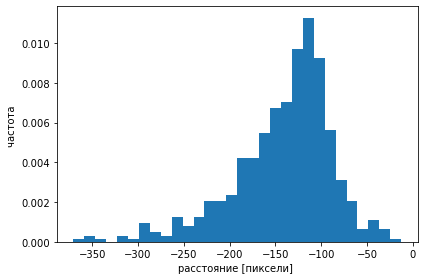

In [47]:
alexnetR = np.load('loss_valueR-AlexnetR.npy')
print(alexnetR.shape, sum(np.isnan(alexnetR)))

fig, axs = plt.subplots(1, 1, tight_layout=True)
plt.hist(alexnetR, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

(535,) 0


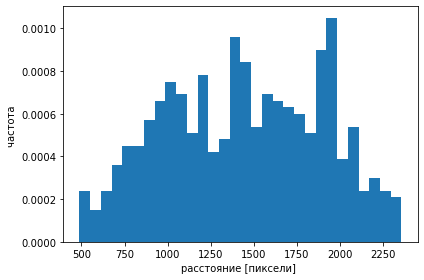

In [48]:
alexnetXY = np.load('loss_value-AlexnetXY.npy')
print(alexnetXY.shape, sum(np.isnan(alexnetXY)))

fig, axs = plt.subplots(1, 1, tight_layout=True)
plt.hist(alexnetXY, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

(535,) 0


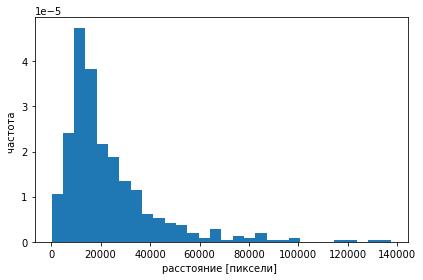

In [50]:
alexnetR2 = np.load('loss_valueR-AlexnetR2.npy')
print(alexnetR2.shape, sum(np.isnan(alexnetR2)))

fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(alexnetR2, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

In [53]:
print( 'среднее Alexnet XY' , alexnetXY.sum()/alexnetXY.size)
print('среднее Alexnet R' , alexnetR.sum()/alexnetR.size)
print('среднее Alexnet R^2' , alexnetR2.sum()/alexnetR2.size)
print('Alexnet радиус RMSE ' , np.sqrt(alexnetR.sum()/alexnetR.size))
alexnetR.size
alexnetR.sum()
print('Unet радиус RMSE ' , np.sqrt(unetR2.sum()/unetR.size))
print('классический алгоритм радиус RMSE  ' , np.sqrt(classicR2.sum()/classicR2.size))

среднее Alexnet XY 1442.4031406241704
среднее Alexnet R -141.47928933635507
среднее Alexnet R^2 22992.269460849926
Alexnet радиус RMSE  nan


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


-75691.41979494996

In [63]:
loss_valueXY = []
loss_valueR = []
loss_valueR2 = []
for batch_idx , data in enumerate(val_loader):
    data_image = data['image']
    data_image = data_image.to(device1) # отправили на GPU
    target = torch.squeeze(data['landmarks'])
    data_out = model(data_image) # получили сегментированную фотку
    out_np = np.squeeze(data_out.detach().cpu().numpy())
    target_np = np.squeeze(target.detach().cpu().numpy())
    
    
    out_img = cv2.resize(out_np, (1920, 1920)) # обратный ресайз
    out_img = (out_img>0.5).astype(np.uint8) # убрали проблемы интерполяции
    
    
#     image = resize(out_np)
#     x,y,r = findXYR(image)
   # print(out_img.shape)
    x_matrix = np.arange(0, 1920, 1)[np.newaxis,:] # далее находим центр масс и радиус
    x_matrix = np.tile(x_matrix, (1920, 1))

    y_matrix = np.arange(0, 1920, 1)[:, np.newaxis]
    y_matrix = np.tile(y_matrix, (1, 1920))

    x_center = np.sum(out_img*x_matrix)/np.sum(out_img)
    y_center = np.sum(out_img*y_matrix)/np.sum(out_img)
    radius = np.sqrt(np.sum(out_img)/np.pi)
    
    if  np.sum(out_img) > 0:
    
        lossXY = np.sqrt((x_center-target_np[0])**2+(y_center-target_np[1])**2 )
        lossR2 = (radius - target_np[2])**2
        lossR = (radius - target_np[2])

        loss_valueXY = np.append(loss_valueXY,lossXY) # добавляю в массив значение функци потерь
        loss_valueR = np.append(loss_valueR,lossR)
        loss_valueR2 = np.append(loss_valueR2,lossR2)
        np.save('loss_value-unetXY',loss_valueXY )
        np.save('loss_valueR-unetR',loss_valueR )
        np.save('loss_valueR-unetR2',loss_valueR2 )

   # out_img_rgb = cv2.cvtColor(image*255, cv2.COLOR_GRAY2RGB)
   # print(x_matrix)
#     print(np.sum(out_img), x_center,y_center,radius)
#     if np.sum(out_img)>0:
#         loss_valueX = np.append(loss_valueX,x) # добавляю в массив значение функци потерь
#         loss_valueY = np.append(loss_valueXY,y)
#         loss_valueR = np.append(loss_valueR,radius)
#         np.save('loss_value-unetX',loss_valueX )
#         np.save('loss_valueXY-unetY',loss_valueY )
#         np.save('loss_valueR-unetR',loss_valueR )
#     else:
#         loss_valueX = np.append(loss_valueX,0) # добавляю в массив значение функци потерь
#         loss_valueY = np.append(loss_valueXY,0)
#         loss_valueR = np.append(loss_valueR,0)
#         np.save('loss_value-unetX',loss_valueX )
#         np.save('loss_valueXY-unetY',loss_valueY )
#         np.save('loss_valueR-unetR',loss_valueR )
        

    #break

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


(223,) 0


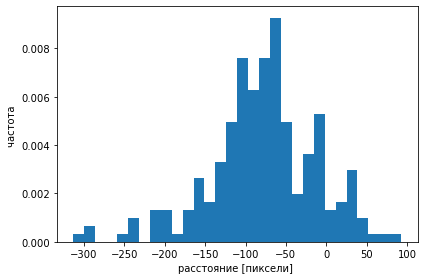

In [62]:
unetR = np.load('loss_valueR-unetR.npy')
print(unetR.shape, sum(np.isnan(unetR)))

fig, axs = plt.subplots(1, 1, tight_layout=True)
plt.hist(unetR, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

(223,) 0


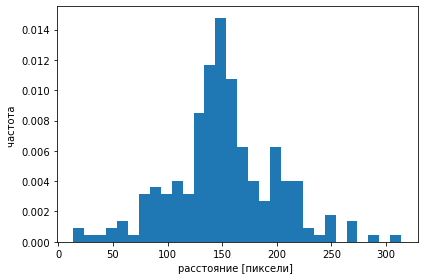

In [18]:
unetXY = np.load('loss_value-unetXY.npy')
print(unetXY.shape, sum(np.isnan(unetXY)))

fig, axs = plt.subplots(1, 1, tight_layout=True)
plt.hist(unetXY, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

(223,) 0


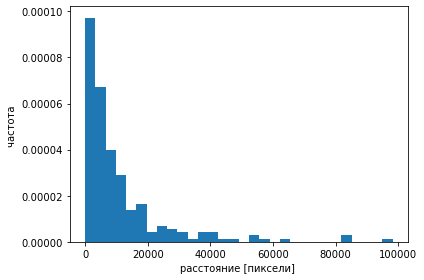

In [19]:
unetR2 = np.load('loss_valueR-unetR2.npy')
print(unetR2.shape, sum(np.isnan(unetR2)))

fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(unetR2, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

In [64]:
loss_valueXY = []
loss_valueR2 = []
loss_valueR2 = []
for batch_idx , data in enumerate(val_loader):
    data_image = data['image']
    data_image = data_image.to(device1) # отправили на GPU
    target = torch.squeeze(data['landmarks'])
    
    out_np = np.squeeze(data_image.detach().cpu().numpy())
    out_np = out_np.transpose((1, 2, 0))        
    
    img_classic = cv2.resize(out_np, (1920, 1920))
    img_classic = cv2.cvtColor(img_classic, cv2.COLOR_RGB2GRAY)
    img_classic_th = (img_classic>=250).astype(np.uint8)
    
    target_np = np.squeeze(target.detach().cpu().numpy())
    
    x_matrix = np.arange(0, 1920, 1)[np.newaxis,:] # далее находим центр масс и радиус
    x_matrix = np.tile(x_matrix, (1920, 1))

    y_matrix = np.arange(0, 1920, 1)[:, np.newaxis]
    y_matrix = np.tile(y_matrix, (1, 1920))

    x_center = np.sum(img_classic_th*x_matrix)/np.sum(img_classic_th)
    y_center = np.sum(img_classic_th*y_matrix)/np.sum(img_classic_th)
    radius = np.sqrt(np.sum(img_classic_th)/np.pi)
    
#     if  np.sum(out_img) == 0:
#         x_center, y_center, radius = 0, 0 , 0
    
    
    lossXY = np.sqrt((x_center-target_np[0])**2+(y_center-target_np[1])**2 )
    lossR2 = (radius - target_np[2])**2
    lossR = (radius - target_np[2])
#     if np.sum(img_classic_th) ==0:
#         plt.figure()

#         #subplot(r,c) provide the no. of rows and columns
#         f, axarr = plt.subplots(2,1) 

#         # use the created array to output your multiple images. In this case I have stacked 4 images vertically
#         axarr[0].imshow(img_classic_th, cmap='gray', origin='lower')
#         axarr[1].imshow(img_classic, cmap='gray', origin='lower')
#         break
    if np.sum(img_classic_th) > 0:
        loss_valueXY = np.append(loss_valueXY,lossXY) # добавляю в массив значение функци потерь
        loss_valueR2 = np.append(loss_valueR2,lossR2)
        loss_valueR = np.append(loss_valueR,lossR)
        
        np.save('loss_value-classicXY',loss_valueXY )
        np.save('loss_valueR-classicR2',loss_valueR2 )
        np.save('loss_valueR-classicR',loss_valueR )


In [22]:
bestRmse = None
koef = 0.50 
#bestRmse = 0.0
while koef < 1.50:
    loss_valueXY = []
    loss_valueR2 = []
    loss_valueR = []
    for batch_idx , data in enumerate(val_loader):
        data_image = data['image']
        data_image = data_image.to(device1) # отправили на GPU
        target = torch.squeeze(data['landmarks'])

        out_np = np.squeeze(data_image.detach().cpu().numpy())
        out_np = out_np.transpose((1, 2, 0))        

        img_classic = cv2.resize(out_np, (1920, 1920))
        img_classic = cv2.cvtColor(img_classic, cv2.COLOR_RGB2GRAY)
        img_classic_th = (img_classic>=250).astype(np.uint8)

        target_np = np.squeeze(target.detach().cpu().numpy())

        x_matrix = np.arange(0, 1920, 1)[np.newaxis,:] # далее находим центр масс и радиус
        x_matrix = np.tile(x_matrix, (1920, 1))

        y_matrix = np.arange(0, 1920, 1)[:, np.newaxis]
        y_matrix = np.tile(y_matrix, (1, 1920))

        x_center = np.sum(img_classic_th*x_matrix)/np.sum(img_classic_th)
        y_center = np.sum(img_classic_th*y_matrix)/np.sum(img_classic_th)
        radius = np.sqrt(np.sum(img_classic_th)/np.pi)

    #     if  np.sum(out_img) == 0:
    #         x_center, y_center, radius = 0, 0 , 0


        lossXY = np.sqrt((x_center-target_np[0])**2+(y_center-target_np[1])**2 )
        lossR2 = (radius - target_np[2])**2
        lossR = (radius - target_np[2])
    #     if np.sum(img_classic_th) ==0:
    #         plt.figure()

    #         #subplot(r,c) provide the no. of rows and columns
    #         f, axarr = plt.subplots(2,1) 

    #         # use the created array to output your multiple images. In this case I have stacked 4 images vertically
    #         axarr[0].imshow(img_classic_th, cmap='gray', origin='lower')
    #         axarr[1].imshow(img_classic, cmap='gray', origin='lower')
    #         break
        if np.sum(img_classic_th) > 0:
            loss_valueXY = np.append(loss_valueXY,lossXY) # добавляю в массив значение функци потерь
            loss_valueR2 = np.append(loss_valueR2,lossR2)
            loss_valueR = np.append(loss_valueR,lossR)

        if bestRmse == None or bestRmse > np.sqrt(loss_valueR.sum()/loss_valueR.size):
            bestRmse = np.sqrt(loss_valueR.sum()/loss_valueR.size)
    np.save('loss_value-classicXY-best',loss_valueXY )
    np.save('loss_valueR-classicR2-best',loss_valueR2 )
    np.save('loss_valueR-classicR-best',loss_valueR )
    koef = koef+0.01
    print(bestRmse,koef)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in sqrt
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in sqrt


nan 0.51
nan 0.52
nan 0.53


KeyboardInterrupt: 

In [ ]:
5+2

(758,) 0


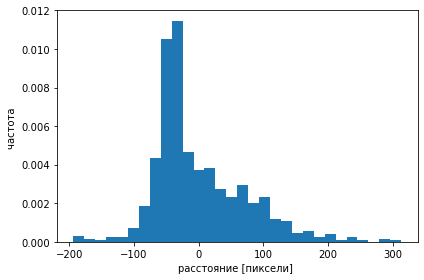

In [66]:
classicR = np.load('loss_valueR-classicR.npy')
print(classicR.shape, sum(np.isnan(classicR)))

fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(classicR, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')


In [82]:
#classicR.size
print( 'среднее классический алгоритм XY' , classicXY.sum()/classicXY.size)
print('среднее классический алгоритм R' , classicR.sum()/classicR.size)
print('среднее классический алгоритм R^2' , classicR2.sum()/classicR2.size)
print('среднее Unet XY' , unetXY.sum()/unetXY.size)
print('среднее Unet R' , unetR.sum()/unetR.size)
print('среднее Unet R^2' , unetR2.sum()/unetR2.size)
print('Unet радиус RMSE ' , np.sqrt(unetR2.sum()/unetR.size))
print('классический алгоритм радиус RMSE  ' , np.sqrt(classicR2.sum()/classicR2.size))

среднее классический алгоритм XY 28.0395836116312
среднее классический алгоритм R -0.5513632970952901
среднее классический алгоритм R^2 2639.3653672316946
среднее Unet XY 151.6162685565937
среднее Unet R -78.83958351176503
среднее Unet R^2 10678.094804025452
Unet радиус RMSE  103.33486731991991
классический алгоритм радиус RMSE   51.3747541817155


(535,) 0


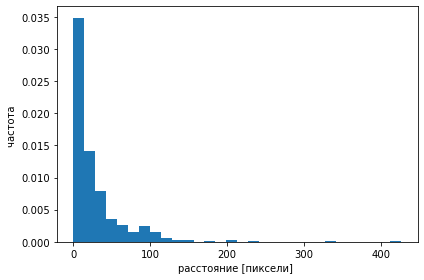

In [55]:
classicXY = np.load('loss_value-classicXY.npy')
print(classicXY.shape, sum(np.isnan(classicXY)))

fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(classicXY, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

(535,) 0


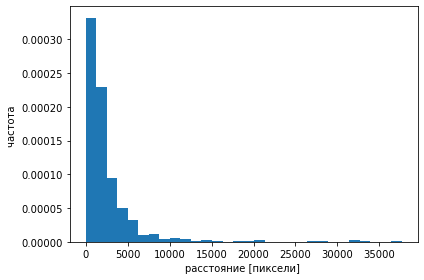

In [56]:
classicR2 = np.load('loss_valueR-classicR2.npy')
print(classicR2.shape, sum(np.isnan(classicR2)))

fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(classicR2, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

In [ ]:
# размер шрифта
plt.rcParams.update({'font.size': 10})

In [ ]:
fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(a, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

#plt.xlabel('распределение RMSE ошибки между оценкой эксперта и классического алгоритма ')
#axs.yaxis.set_major_formatter(PercentFormatter(xmax=1))


In [ ]:
b = np.load('loss_valueR-classicR.npy')

In [ ]:
b.shape

In [ ]:
fig, axs = plt.subplots(1, 1, tight_layout=True)

plt.hist(b, density = True, bins = 30 )
plt.ylabel('частота ')
plt.xlabel('расстояние [пиксели] ')
fig.patch.set_facecolor('white')

In [ ]:
a1[0:10]

In [ ]:
plt.hist(b[0], )

In [ ]:
b[0]

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(b[0], b[1])
#plt.imshow(b[0],b[1]) 